In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import glob
import os
import numpy as np
import seaborn as sns
import matplotlib.style as style
import matplotlib.cm as cm

from matplotlib.colors import Normalize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut
from scipy.interpolate import UnivariateSpline
from matplotlib.backends.backend_pdf import PdfPages

style.use('default')

# Change the default math mode font to normal
plt.rcParams['mathtext.default'] = 'regular'

# Outliers manual cleaning
While exploring the relationships between water chemistry and discharge, Areti identified some obvious outliers. These outliers were removed, and the data was saved as a new CSV file

## 1. User input

In [2]:
# Input file paths
chem_infile = r'../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_wc_flagged_2024.csv'
q_directory = r'../../data/river/discharge/clean'

# Variables to log transform
wc_vars_to_log_transform = ['DOC_mg/L C',  'Farge_mg Pt/l', 'NH4-N_µg/l', 'NO3-N_µg/l', 'PO4-P_µg/l',  
                            'STS_mg/l', 'SiO2_mg/l', 'TOC_mg/l', 'TOTN_µg/l', 'TOTP/F_µg/l P', 'TOTP_P_µg/l P', 
                            'TSM_mg/l', 'UV-Abs. 410nm_Abs/cm', 'discharge']

# Log-transformed chemistry variables 
wc_vars_log = ['log10_DOC_mg/L C','log10_Farge_mg Pt/l', 'log10_NH4-N_µg/l', 'log10_NO3-N_µg/l',
               'log10_PO4-P_µg/l', 'log10_STS_mg/l', 'log10_SiO2_mg/l', 'log10_TOC_mg/l', 'log10_TOTN_µg/l',
               'log10_TOTP/F_µg/l P', 'log10_TOTP_P_µg/l P', 'log10_TSM_mg/l', 'log10_UV-Abs. 410nm_Abs/cm']

# Mapper
river_names_mapper = {
    'Q_daily-mean_Drammenselva_Mjøndalen bru_12': 'discharge_Drammenselva v/Krokstadelva',
    'Q_daily-mean_Glomma_Solbergfoss_2': 'discharge_Glomma v/Sarpefossen',
    'Q_daily-mean_Numedalslågen_Holmfoss_15': 'discharge_Numedalslågen v/E18'
}

## 2. Read in data

***Water chemistry data***

In [3]:
chem_df = pd.read_csv(chem_infile)

# Convert to datetime format
chem_df['sample_date'] = pd.to_datetime(chem_df['sample_date'])
chem_df.set_index('sample_date', inplace=True)
chem_df.head()

,station_id,station_code,station_name,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,NO3-N_µg/l,...,TOTN_µg/l,outlier_TOTN_µg/l,TOTP/F_µg/l P,outlier_TOTP/F_µg/l P,TOTP_P_µg/l P,outlier_TOTP_P_µg/l P,TSM_mg/l,outlier_TSM_mg/l,UV-Abs. 410nm_Abs/cm,outlier_UV-Abs. 410nm_Abs/cm
sample_date,,,,,,,,,,,,,,,,,,,,,
1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,235.0,...,350.0,False,NaN,NaN,NaN,NaN,0.8,False,NaN,NaN
1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,295.0,...,419.0,False,NaN,NaN,NaN,NaN,2.0,False,NaN,NaN
1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,265.0,...,405.0,False,NaN,NaN,NaN,NaN,1.4,False,NaN,NaN
1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,270.0,...,399.0,False,NaN,NaN,NaN,NaN,1.3,False,NaN,NaN
1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,178.0,...,317.0,False,NaN,NaN,NaN,NaN,1.7,False,NaN,NaN


***Discharge data***

In [4]:
# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(q_directory, '*.csv'))

# Initialize an empty DataFrame to hold the combined data
discharge_df = pd.DataFrame()

# Loop through each file and process it
for file in csv_files:
    # Extract the river name from the file name
    river_name = os.path.basename(file).split('.')[0]
    
    # Read the CSV file
    df = pd.read_csv(file)
    
     # Select the Date and discharge columns, and rename the discharge column
    discharge_column = df[['Date', 'Discharge']].rename(columns={'Discharge': river_names_mapper[river_name]})
    
    # Merge the discharge columns on the Date column
    if discharge_df.empty:
        discharge_df = discharge_column
    else:
        discharge_df = pd.merge(discharge_df, discharge_column, on='Date', how='outer')


# Convert 'Date' to datetime format
discharge_df['Date'] = pd.to_datetime(discharge_df['Date'])

# Extract the year and add it as a new column
# discharge_df['year'] = discharge_df['Date'].dt.year

discharge_df.set_index('Date', inplace=True)

discharge_df.head()

,discharge_Glomma v/Sarpefossen,discharge_Drammenselva v/Krokstadelva,discharge_Numedalslågen v/E18
Date,,,
1990-01-01,425.0,264.681,75.875
1990-01-02,500.0,264.681,75.160
1990-01-03,500.0,260.214,73.044
1990-01-04,500.0,260.214,75.160
1990-01-05,472.0,260.214,81.769


## 3. Regressions
**Note:** I selected discharges based on the dates of the water chemistry dataframe.

In [5]:
# Join the Water chemistry and discharge dataframe  

# Reset index to make 'Date' a column
discharge_df.reset_index(inplace=True)

# Melt discharge dataframe
discharge_long_df = discharge_df.melt(id_vars=['Date'], 
                                      var_name='station_name', 
                                      value_name='discharge')

# Add a new column for station names to the discharge dataframe
discharge_long_df['station_name'] = discharge_long_df['station_name'].str.replace('discharge_', '')

# Convert date column of the discharge dataframe to datetime format
discharge_long_df['Date'] = pd.to_datetime(discharge_long_df['Date'])

# Rename 'sample_date' to 'Date' in water chemistry dataframe
chem_df.reset_index(inplace=True)
chem_df['sample_date'] = chem_df['sample_date'].dt.date
chem_df.rename(columns={'sample_date': 'Date'}, inplace=True)
chem_df['Date'] = pd.to_datetime(chem_df['Date'])

# Merge the dataframes on 'Date' and 'station_name'
merged_df = pd.merge(chem_df, discharge_long_df, 
                     how='inner', 
                     left_on=['Date', 'station_name'], 
                     right_on=['Date', 'station_name'])

# Apply log10 transformation
for var in wc_vars_to_log_transform:
    merged_df[f'log10_{var}'] = np.log10(merged_df[var])

merged_df.head()

/opt/conda/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,station_id,station_code,station_name,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,...,log10_PO4-P_µg/l,log10_STS_mg/l,log10_SiO2_mg/l,log10_TOC_mg/l,log10_TOTN_µg/l,log10_TOTP/F_µg/l P,log10_TOTP_P_µg/l P,log10_TSM_mg/l,log10_UV-Abs. 410nm_Abs/cm,log10_discharge
0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.301030,NaN,NaN,NaN,2.544068,NaN,NaN,-0.096910,NaN,2.415331
1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,0.301030,NaN,NaN,NaN,2.622214,NaN,NaN,0.301030,NaN,2.507367
2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,0.176091,NaN,NaN,NaN,2.607455,NaN,NaN,0.146128,NaN,2.510372
3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,0.176091,NaN,NaN,NaN,2.600973,NaN,NaN,0.113943,NaN,2.537932
4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.301030,NaN,NaN,NaN,2.501059,NaN,NaN,0.230449,NaN,2.510372


/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


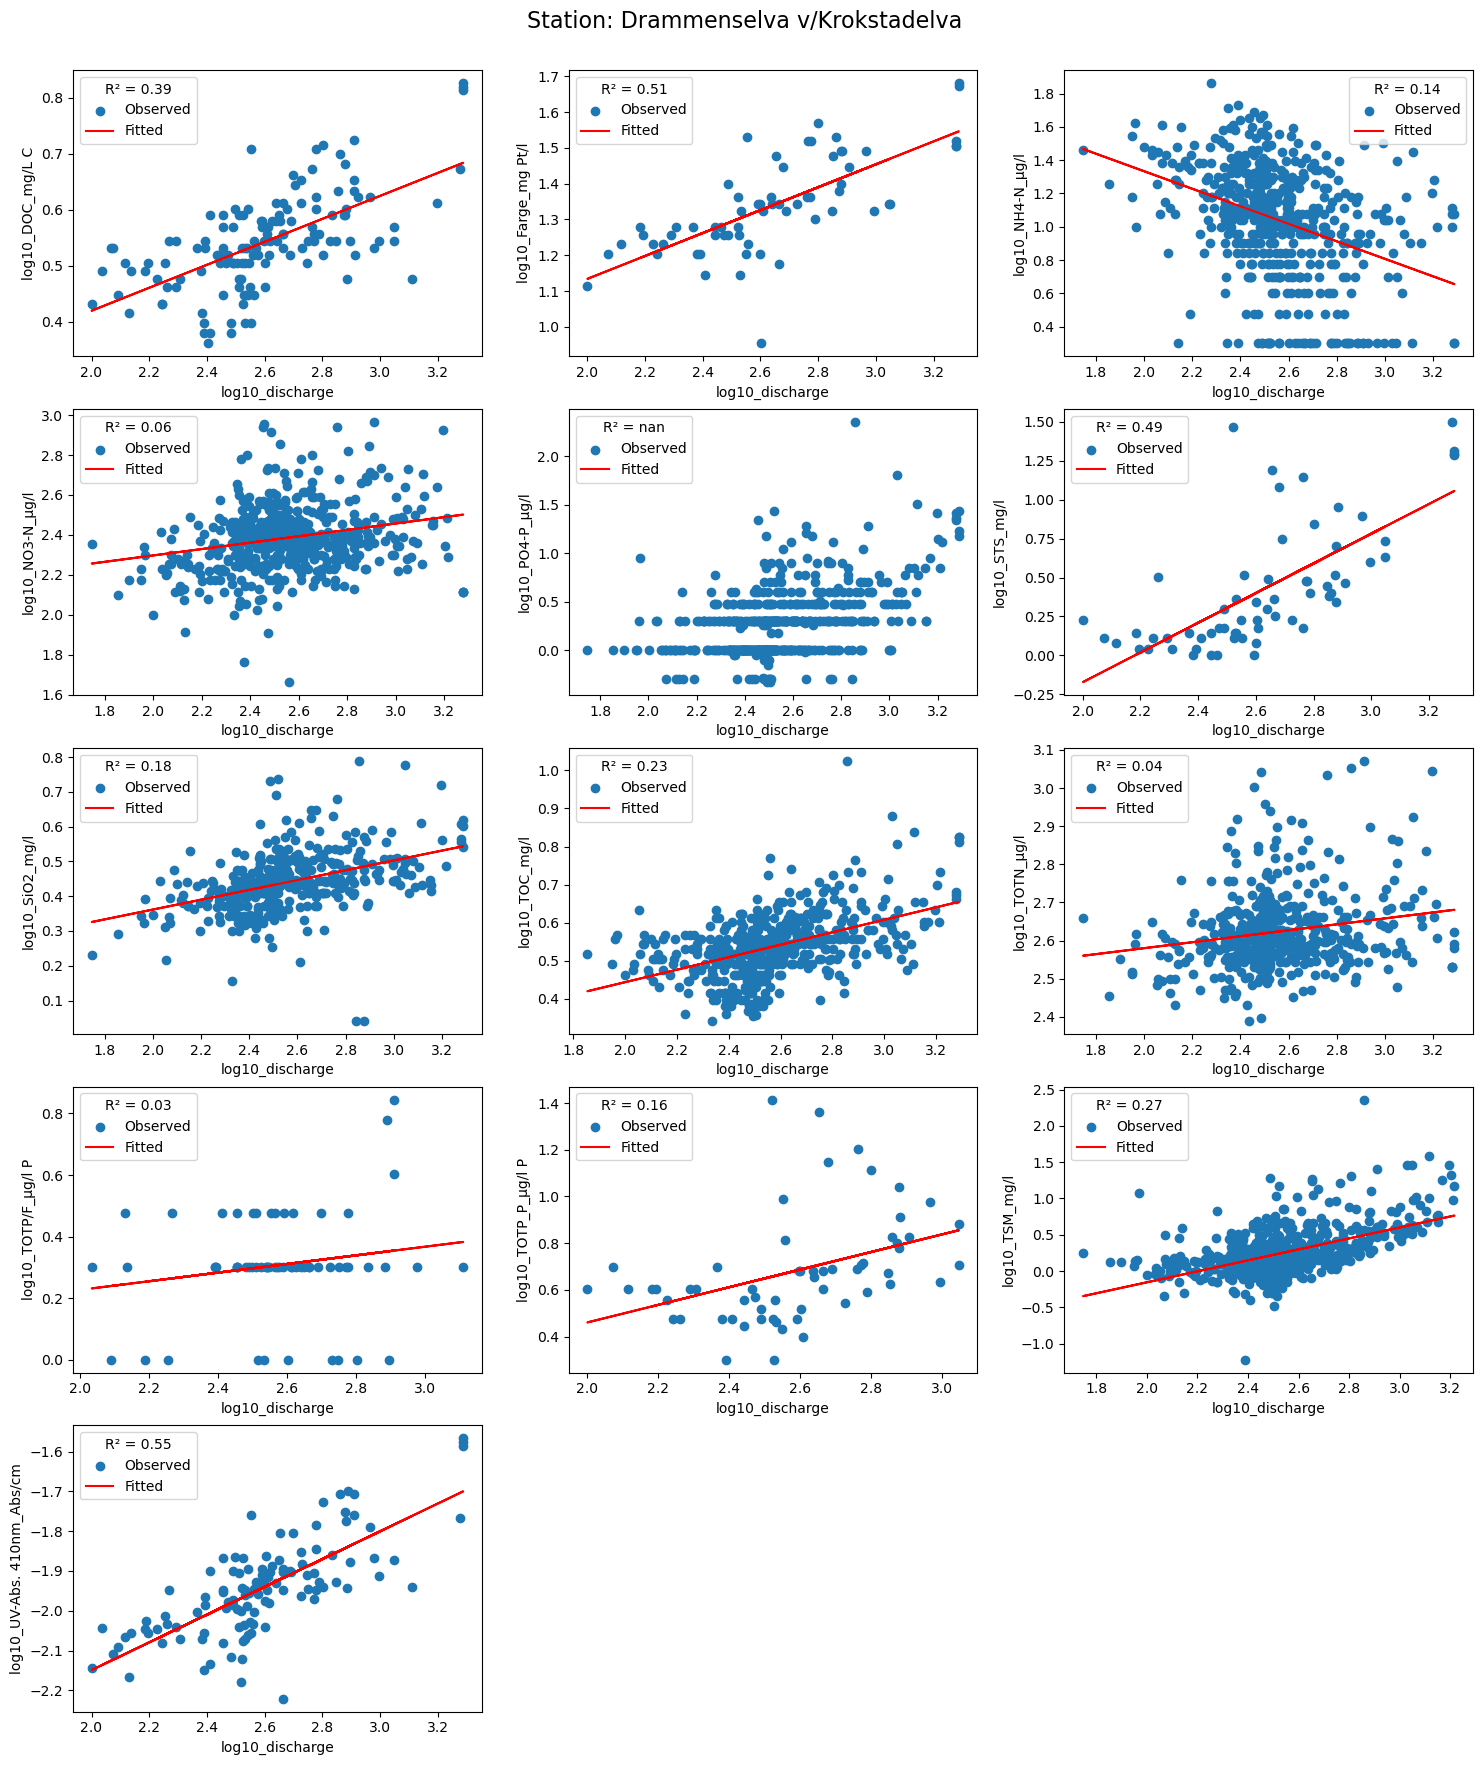

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


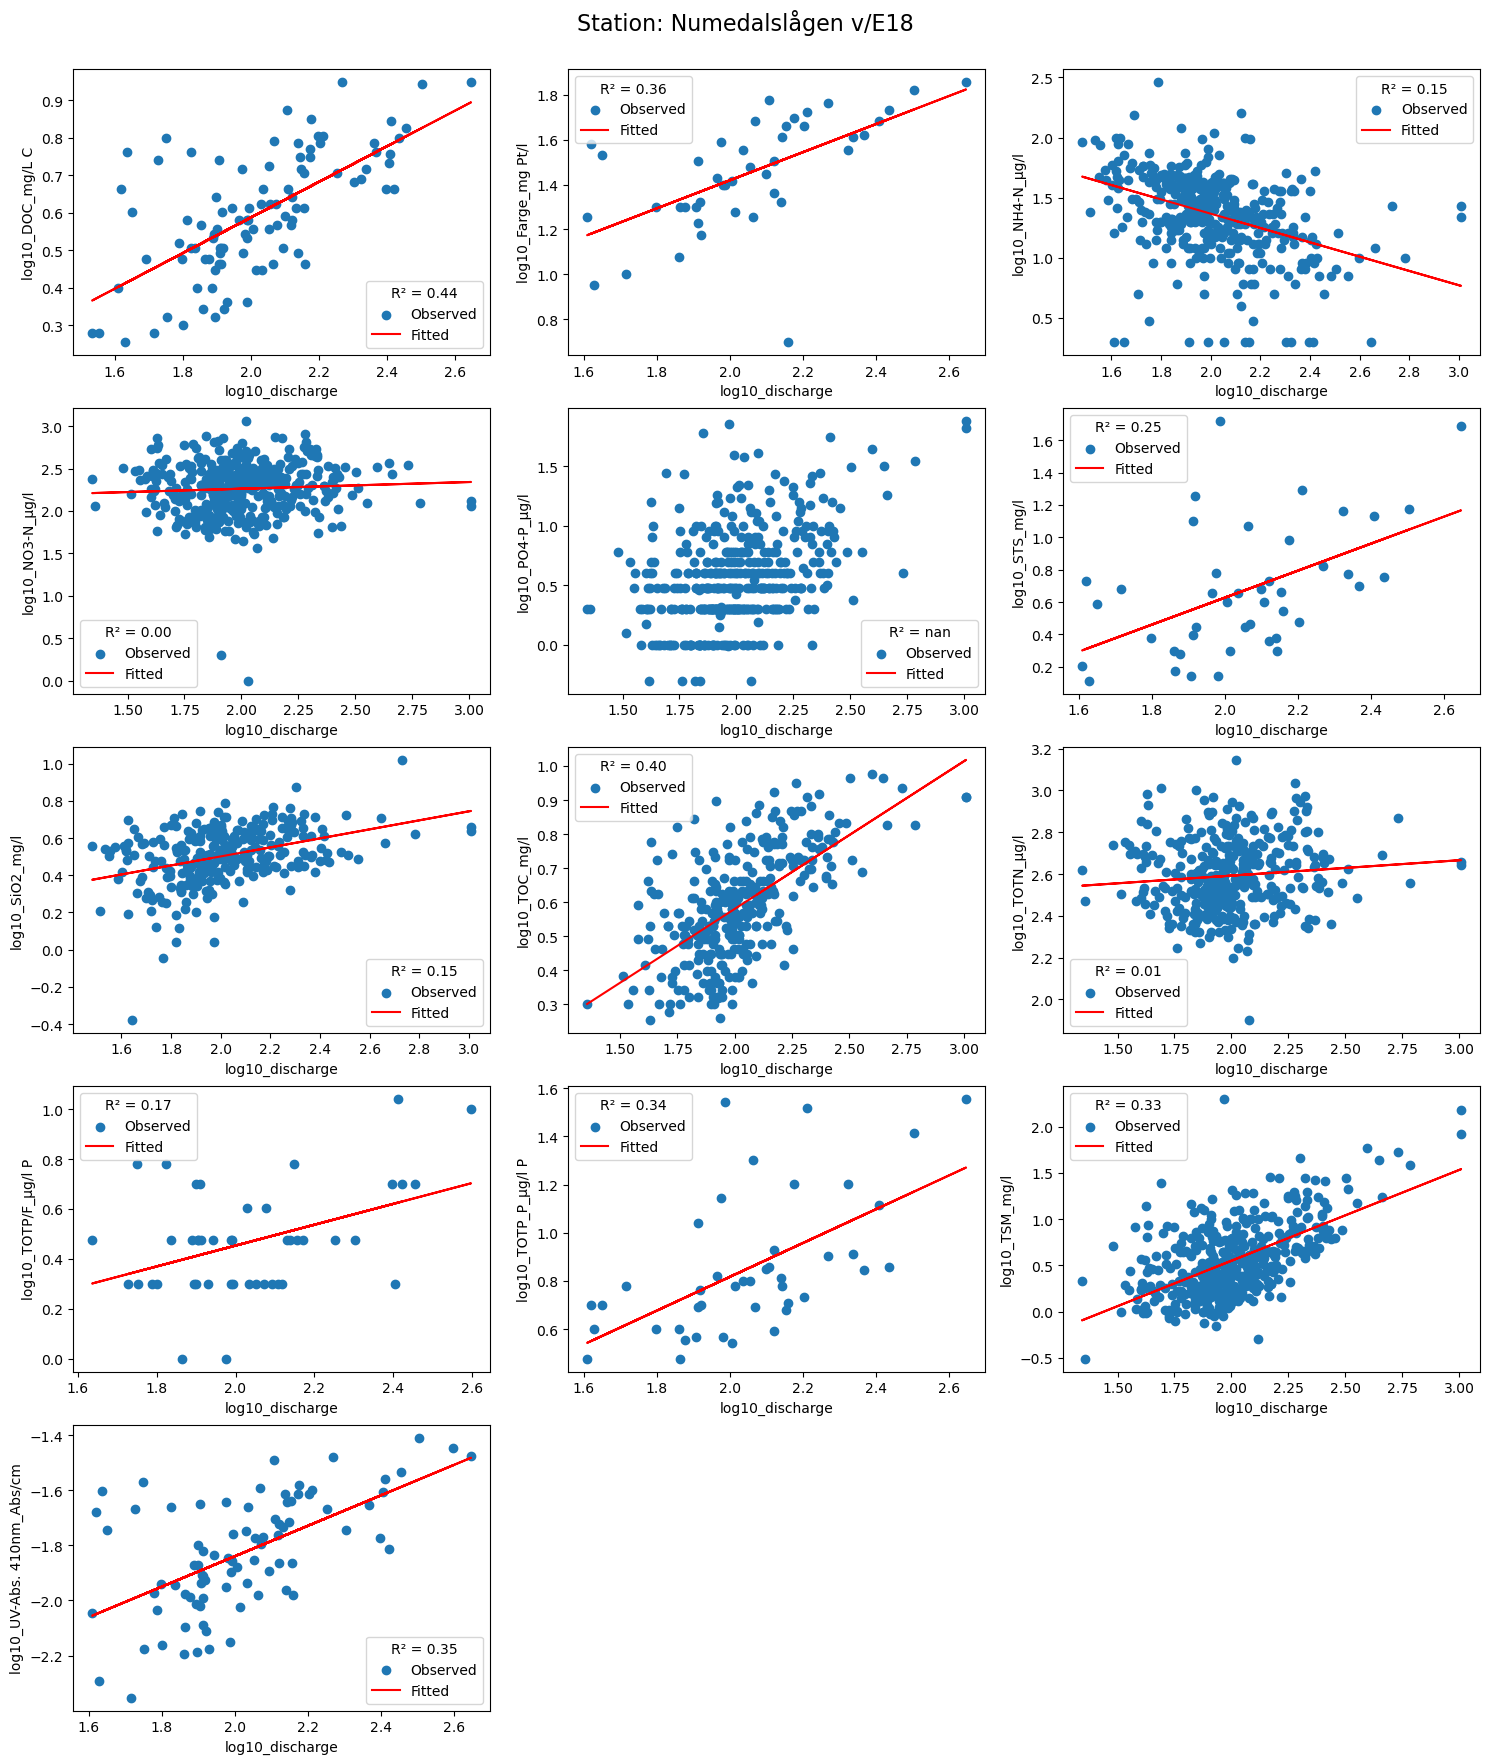

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


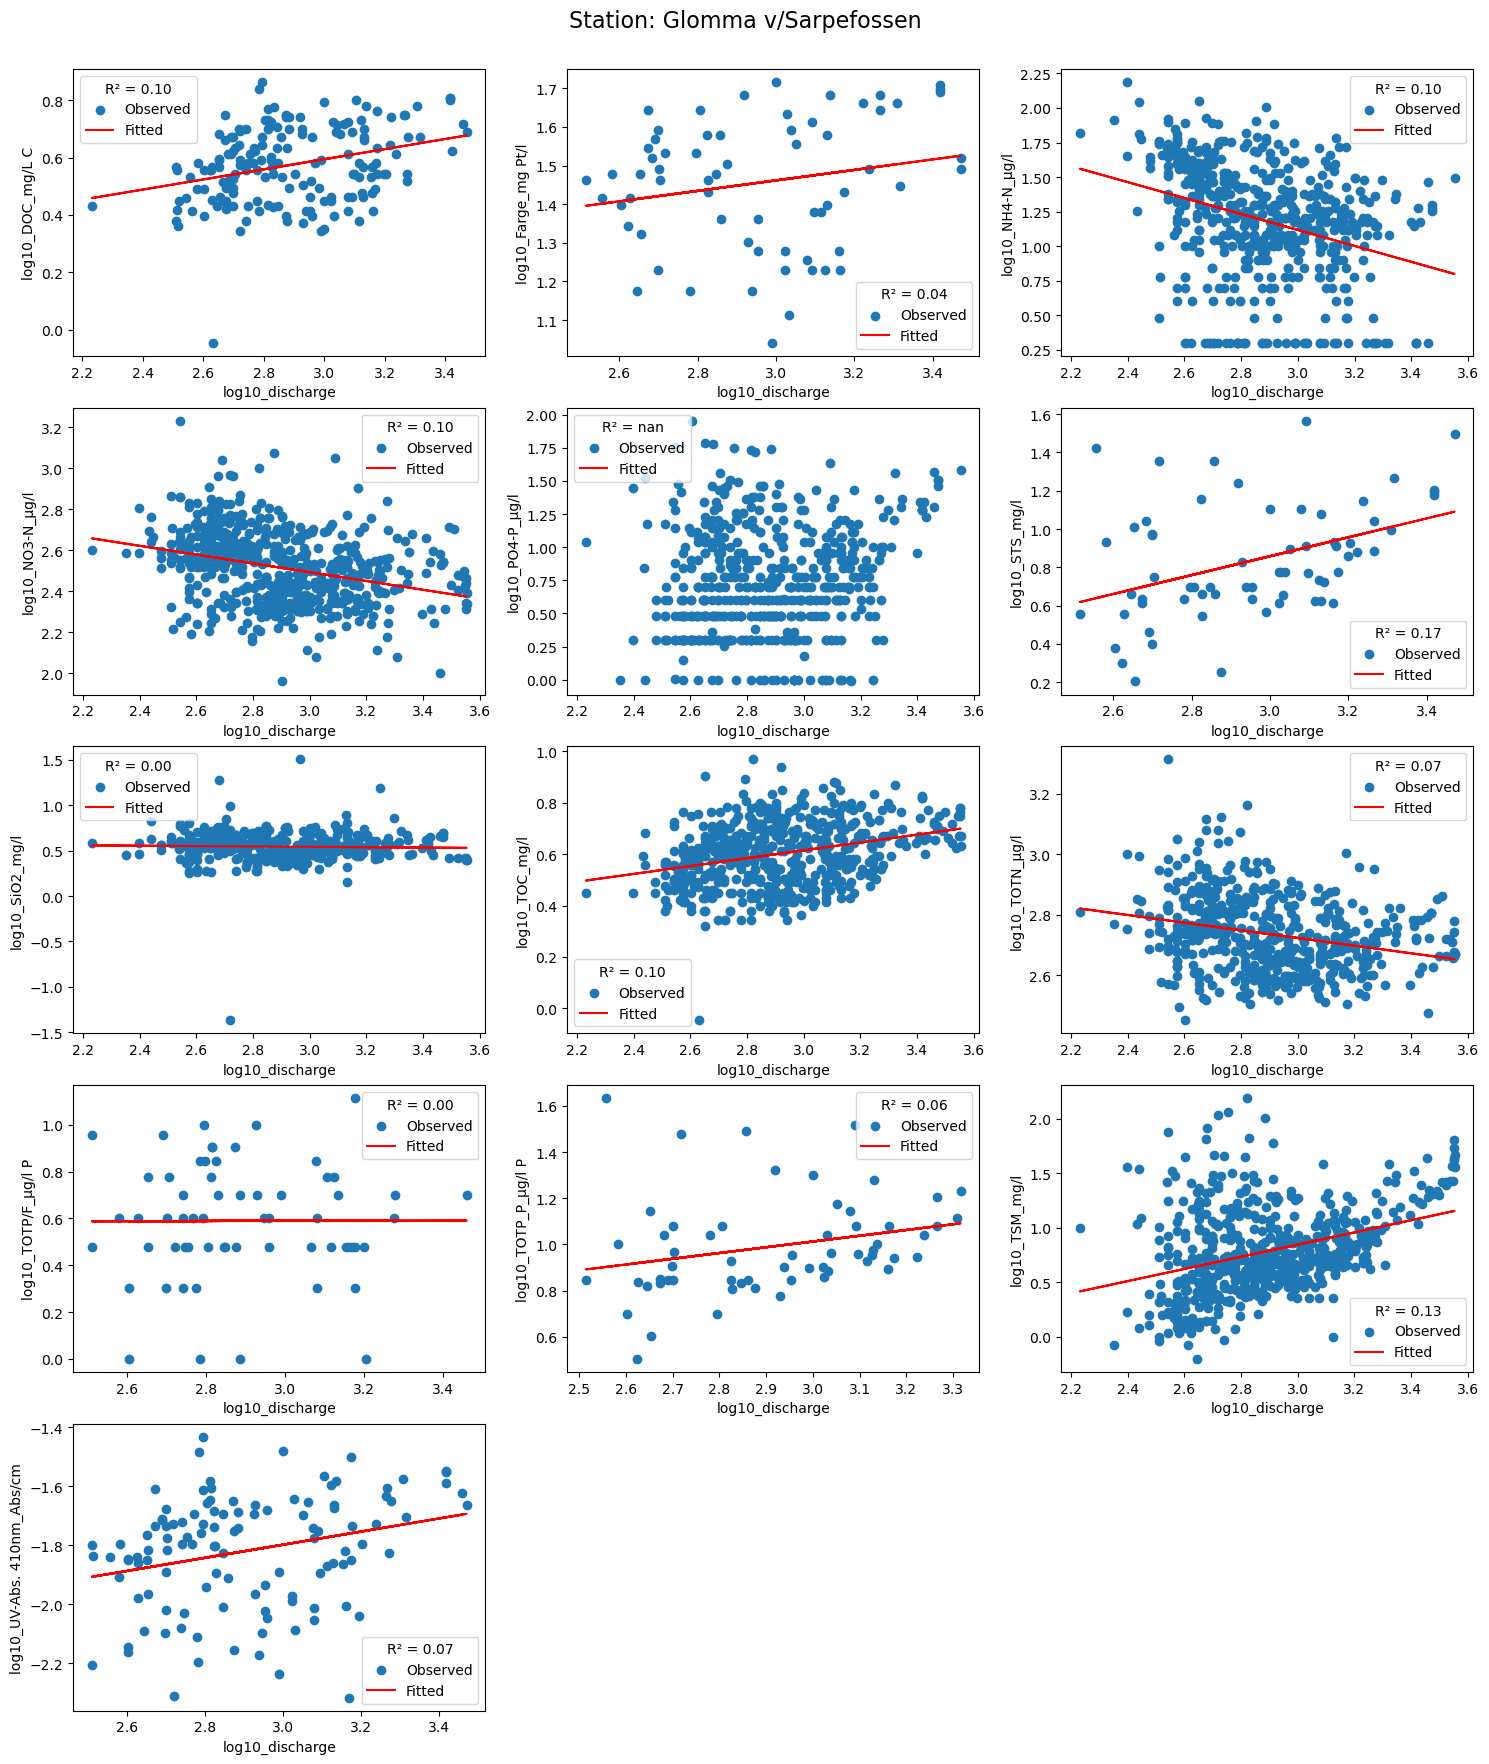

In [6]:
stations = merged_df['station_name'].unique()

model_r2_coeffs_annual = {}

for station in stations:
    station_df = merged_df[merged_df['station_name'] == station]
    
    n = len(wc_vars_log)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 20))
    axs = axs.flatten()
    
    for i, chem_var in enumerate(wc_vars_log):
        df = station_df[['Date', chem_var, 'log10_discharge']].dropna()
    
        if df.empty:
            continue
    
        X = sm.add_constant(df['log10_discharge'])  # independent variable
        y = df[chem_var]  # dependent variable
    
        model = sm.OLS(y, X)
        results = model.fit()
    
        # chem_name = chem_var.split("_")[0]
    
        m, c = results.params['log10_discharge'], results.params['const']
        model_r2_coeffs_annual[(station, chem_var, 'log10_discharge')] = [results.rsquared, m, c]
    
        axs[i].scatter(df['log10_discharge'], df[chem_var], label='Observed')
        axs[i].plot(df['log10_discharge'], results.fittedvalues, color='red', label='Fitted')
        axs[i].set_xlabel('log10_discharge')
        axs[i].set_ylabel(chem_var)
        # axs[i].set_title(f'{station}')
        r2 = results.rsquared
        axs[i].legend(title=f'R² = {r2:.2f}')
    
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top margin to make space for the suptitle
    plt.suptitle(f'Station: {station}', fontsize=16, y=0.88)  # Increase labelpad and adjust y position

    plt.show()

In [7]:
# Flagging the values and replacing with NaN
merged_df.loc[(merged_df['station_name'] == 'Glomma v/Sarpefossen') & (merged_df['log10_DOC_mg/L C'] < 0), ['log10_DOC_mg/L C', 'DOC_mg/L C']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Glomma v/Sarpefossen') & (merged_df['log10_SiO2_mg/l'] < -1), ['log10_SiO2_mg/l', 'SiO2_mg/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Glomma v/Sarpefossen') & (merged_df['log10_TOC_mg/l'] < 0), ['log10_TOC_mg/l', 'TOC_mg/l']] = np.nan

merged_df.loc[(merged_df['station_name'] == 'Numedalslågen v/E18') & (merged_df['log10_NO3-N_µg/l'] < 0.5), ['log10_NO3-N_µg/l', 'NO3-N_µg/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Numedalslågen v/E18') & (merged_df['log10_SiO2_mg/l'] < -0.3), ['log10_SiO2_mg/l', 'SiO2_mg/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Numedalslågen v/E18') & (merged_df['log10_Farge_mg Pt/l'] < 0.8), ['log10_Farge_mg Pt/l', 'Farge_mg Pt/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Numedalslågen v/E18') & (merged_df['log10_TOTN_µg/l'] < 2), ['log10_TOTN_µg/l', 'TOTN_µg/l']] = np.nan

merged_df.loc[(merged_df['station_name'] == 'Drammenselva v/Krokstadelva') & (merged_df['log10_TSM_mg/l'] < -1), ['log10_TSM_mg/l', 'TSM_mg/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Drammenselva v/Krokstadelva') & (merged_df['log10_TSM_mg/l'] > 2), ['log10_TSM_mg/l', 'TSM_mg/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Drammenselva v/Krokstadelva') & (merged_df['log10_SiO2_mg/l'] <0.1), ['log10_SiO2_mg/l', 'SiO2_mg/l']] = np.nan
merged_df.loc[(merged_df['station_name'] == 'Drammenselva v/Krokstadelva') & (merged_df['log10_Farge_mg Pt/l'] < 1), ['log10_Farge_mg Pt/l', 'Farge_mg Pt/l']] = np.nan

merged_df.loc[(merged_df['station_name'] == 'Drammenselva v/Krokstadelva') & (merged_df['log10_PO4-P_µg/l'] > 2), ['log10_PO4-P_µg/l', 'PO4-P_µg/l']] = np.nan

merged_df

,Date,station_id,station_code,station_name,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,...,log10_PO4-P_µg/l,log10_STS_mg/l,log10_SiO2_mg/l,log10_TOC_mg/l,log10_TOTN_µg/l,log10_TOTP/F_µg/l P,log10_TOTP_P_µg/l P,log10_TSM_mg/l,log10_UV-Abs. 410nm_Abs/cm,log10_discharge
0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.301030,NaN,NaN,NaN,2.544068,NaN,NaN,-0.096910,NaN,2.415331
1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,0.301030,NaN,NaN,NaN,2.622214,NaN,NaN,0.301030,NaN,2.507367
2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,0.176091,NaN,NaN,NaN,2.607455,NaN,NaN,0.146128,NaN,2.510372
3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,0.176091,NaN,NaN,NaN,2.600973,NaN,NaN,0.113943,NaN,2.537932
4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.301030,NaN,NaN,NaN,2.501059,NaN,NaN,0.230449,NaN,2.510372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2024-05-22,40356,GLO1,Glomma v/Sarpefossen,3.8,False,27.0,False,10.0,False,...,0.778151,0.778151,0.515874,0.579784,2.505150,NaN,0.939519,0.862728,NaN,3.173107
1625,2024-06-03,40356,GLO1,Glomma v/Sarpefossen,3.0,False,19.0,False,8.0,False,...,0.698970,0.612784,0.498311,0.477121,2.623249,NaN,0.892095,0.645422,NaN,3.160137
1626,2024-06-12,40356,GLO1,Glomma v/Sarpefossen,3.0,False,17.0,False,13.0,False,...,0.602060,0.732394,0.502427,0.477121,2.681241,NaN,0.954243,0.000000,NaN,3.126213
1627,2024-06-20,40356,GLO1,Glomma v/Sarpefossen,3.8,False,24.0,False,9.0,False,...,0.602060,0.623249,0.509203,0.568202,2.672098,NaN,0.929419,0.665581,NaN,3.115271


/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


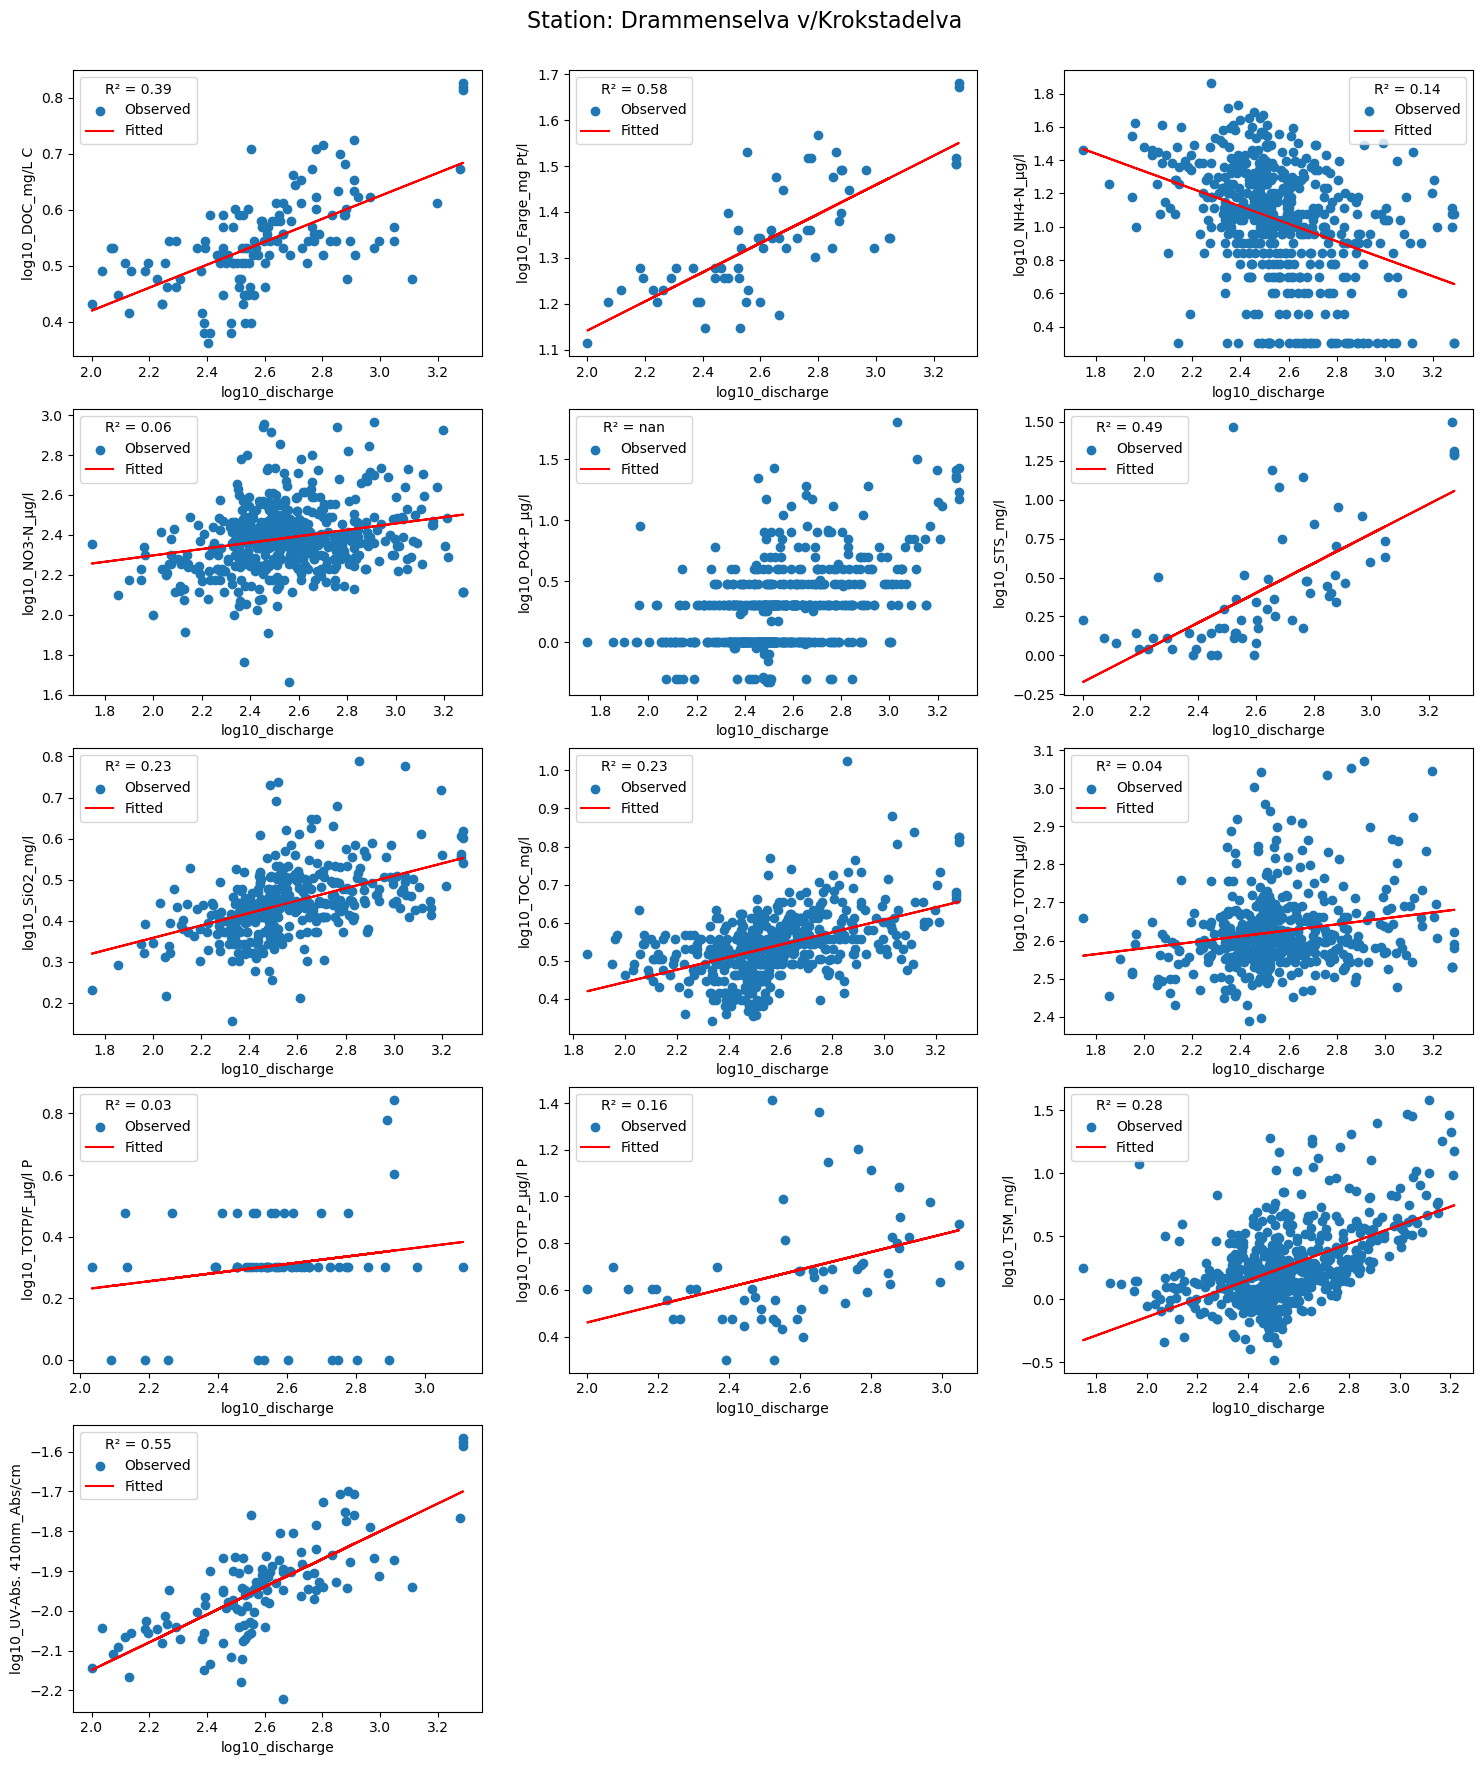

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


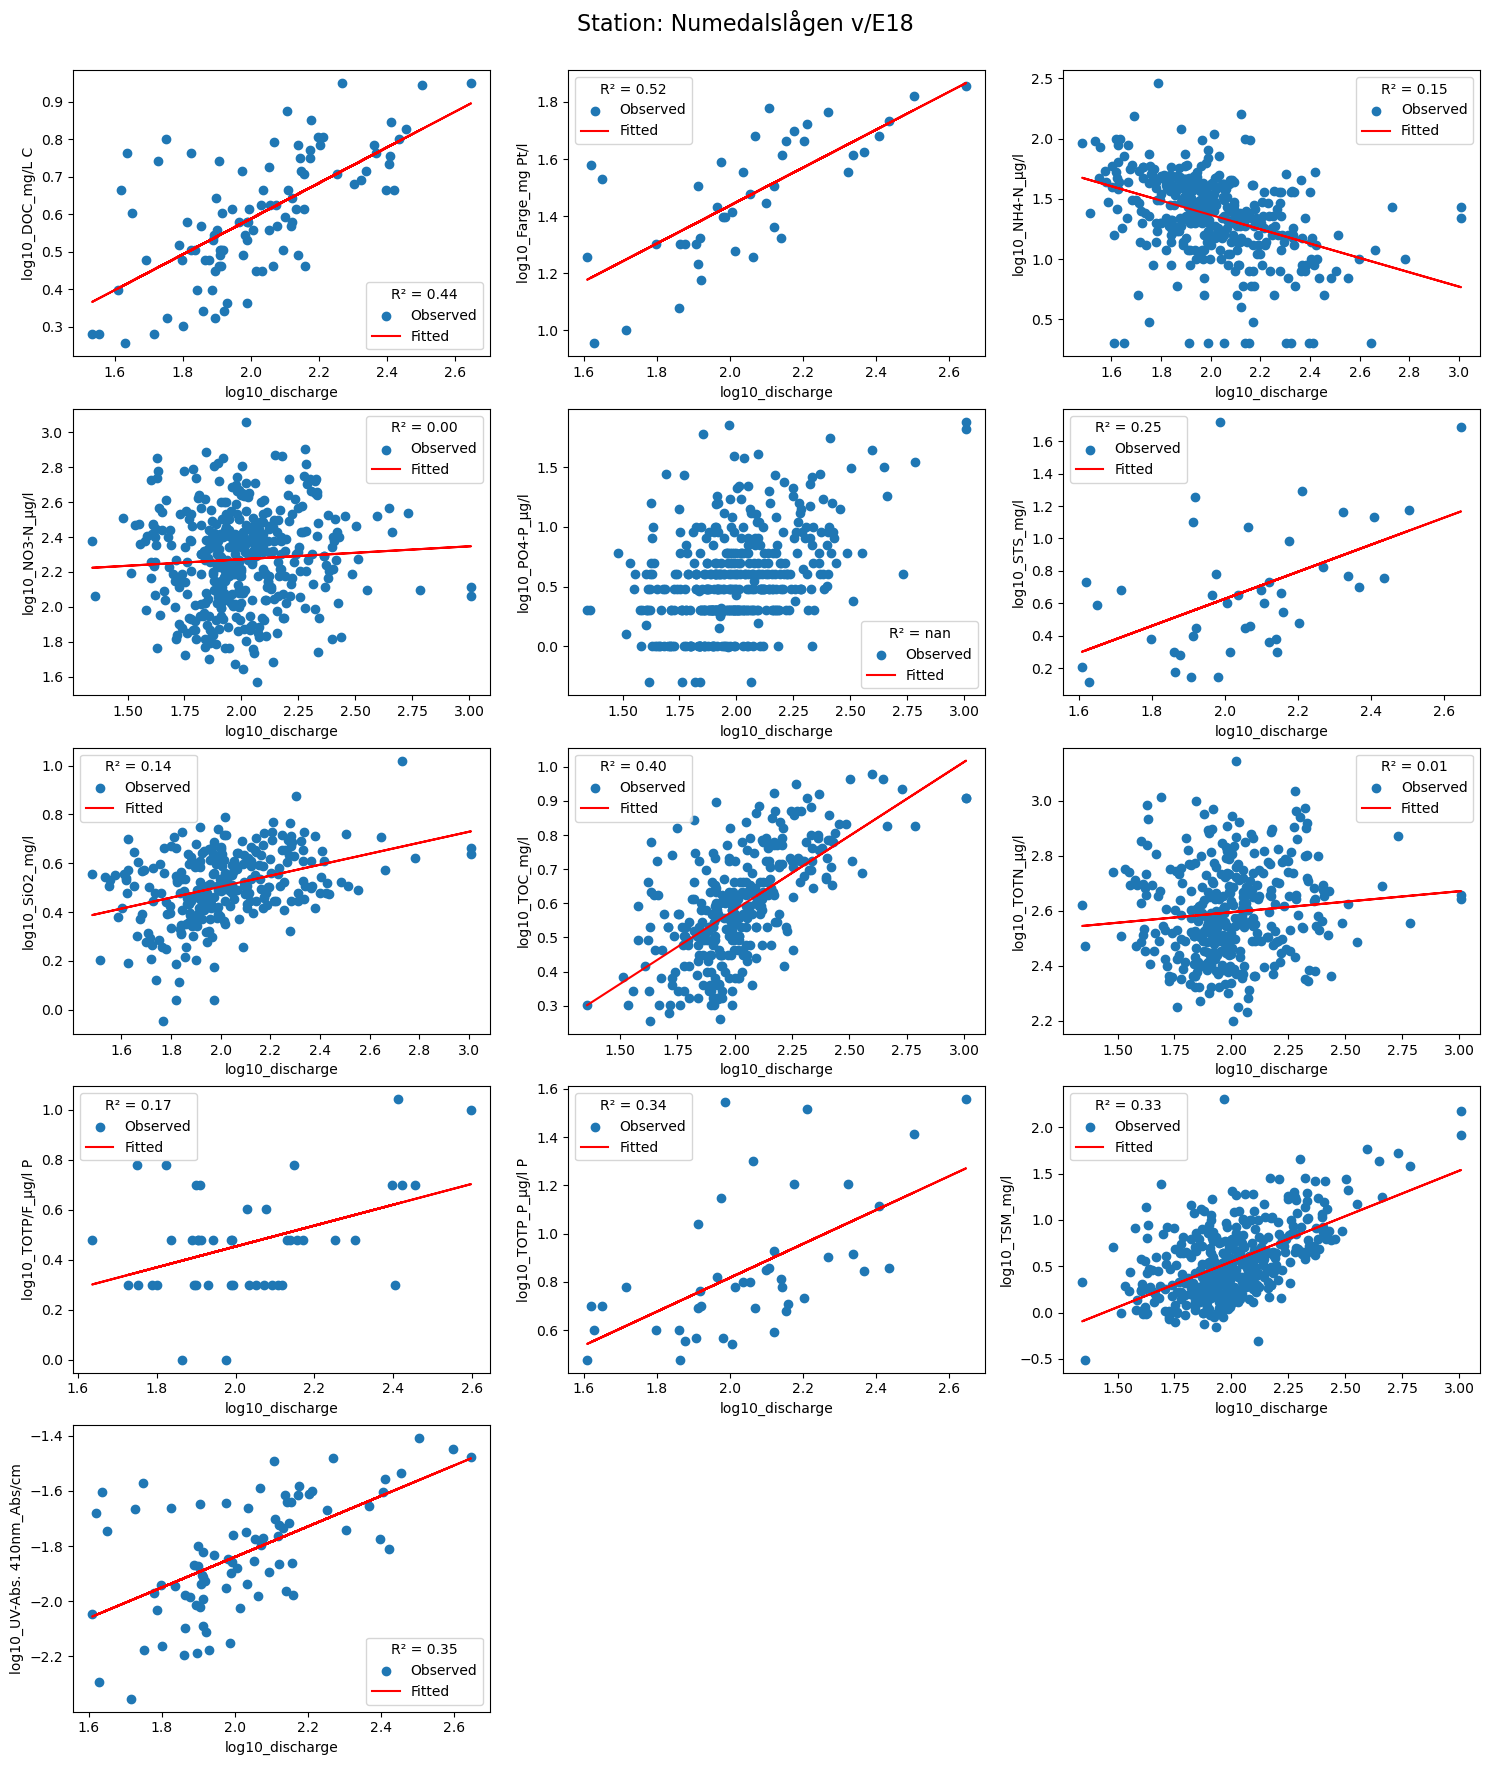

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1733: RuntimeWarning: invalid value encountered in subtract
  return np.sum(weights * (model.endog - mean)**2)


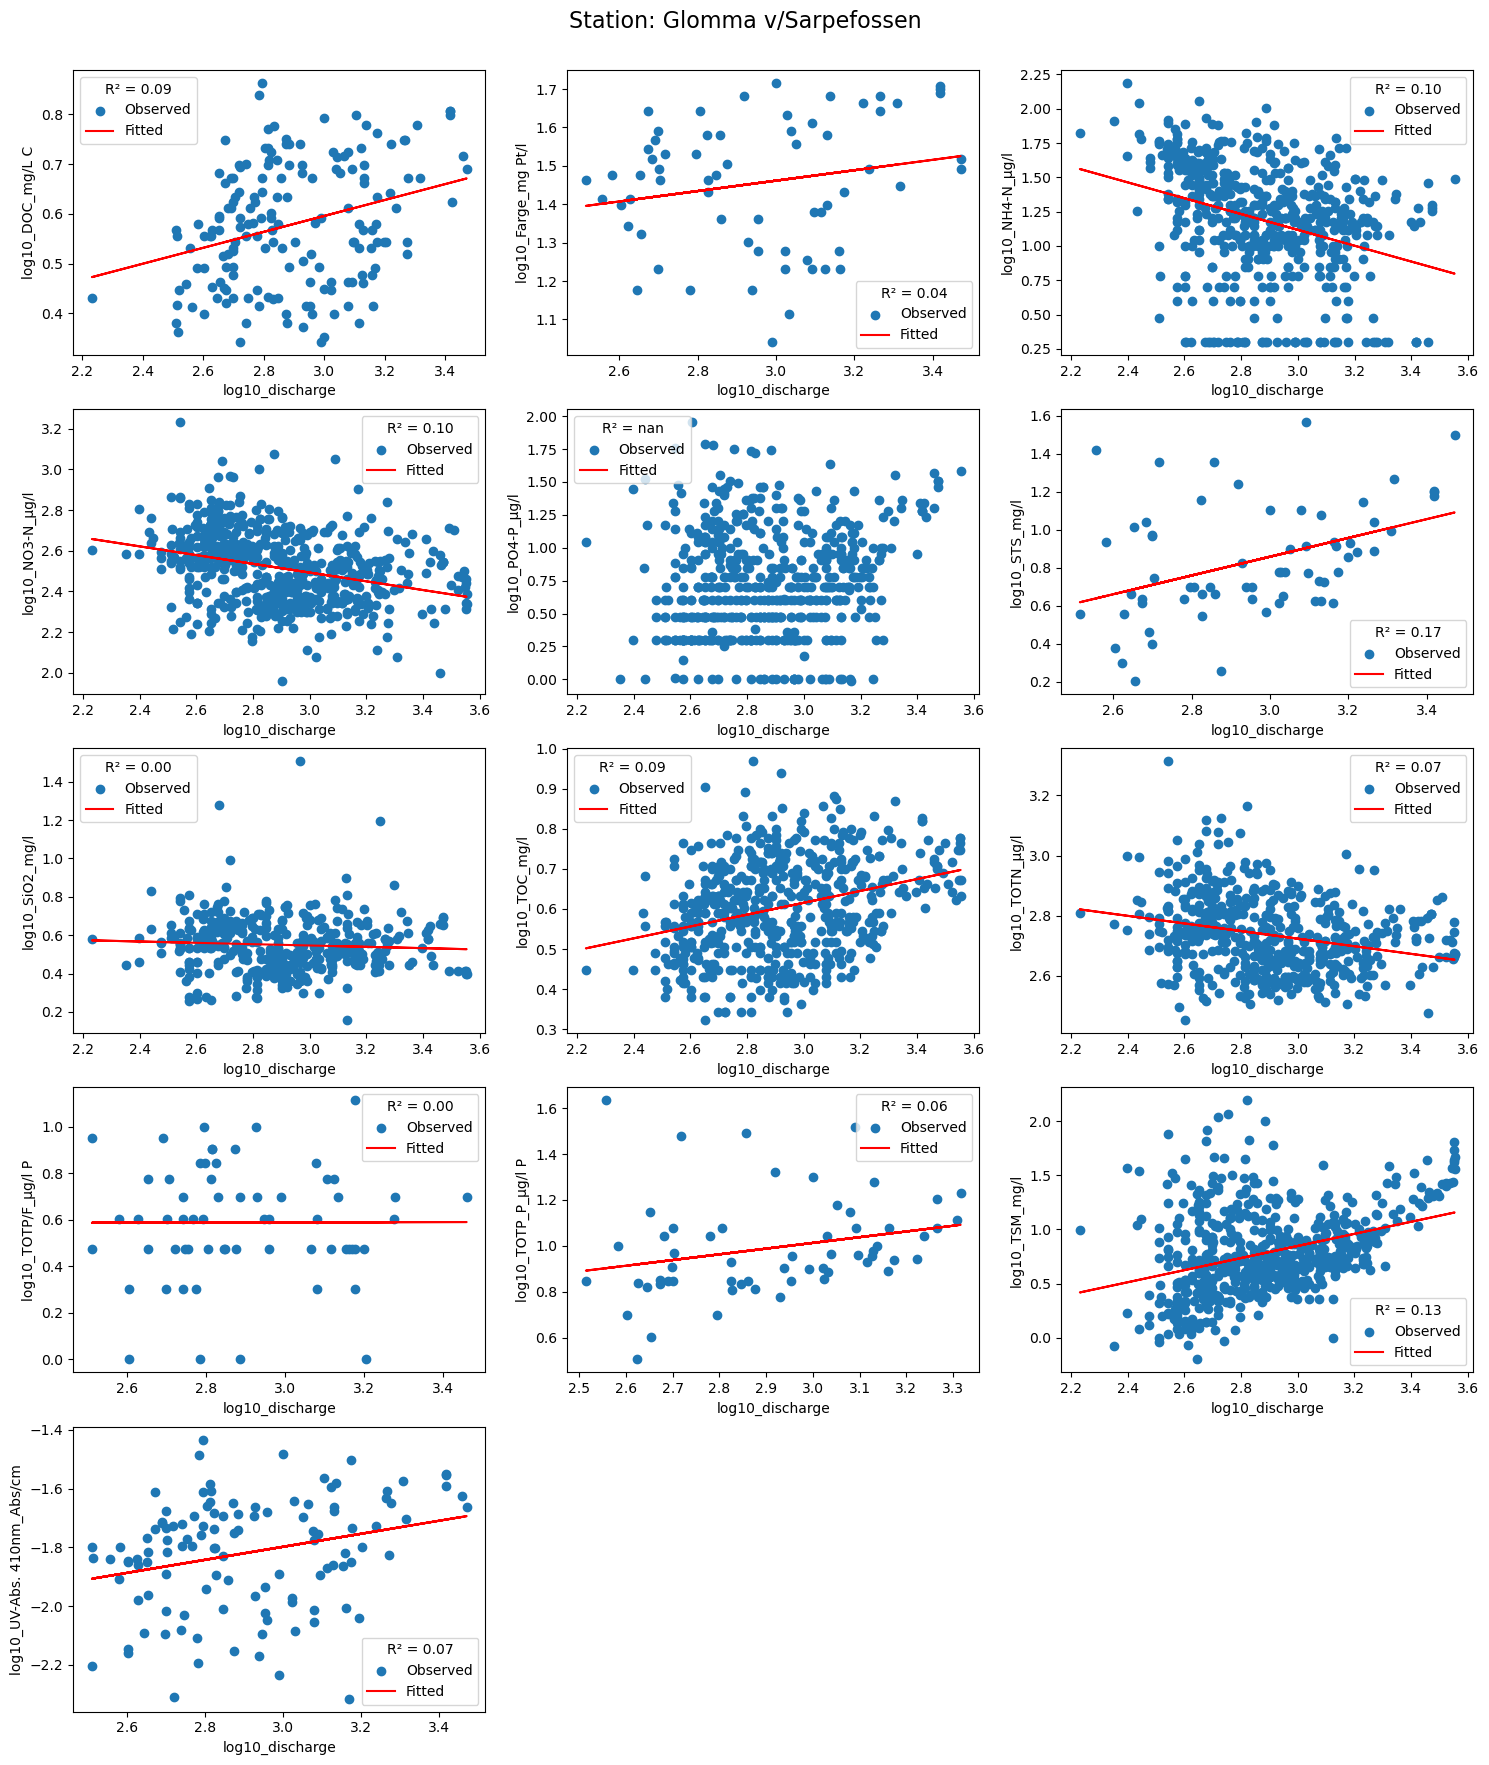

In [8]:
stations = merged_df['station_name'].unique()

model_r2_coeffs_annual = {}

for station in stations:
    station_df = merged_df[merged_df['station_name'] == station]
    
    n = len(wc_vars_log)
    ncols = 3
    nrows = int(np.ceil(n / ncols))
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(15, 20))
    axs = axs.flatten()
    
    for i, chem_var in enumerate(wc_vars_log):
        df = station_df[['Date', chem_var, 'log10_discharge']].dropna()
    
        if df.empty:
            continue
    
        X = sm.add_constant(df['log10_discharge'])  # independent variable
        y = df[chem_var]  # dependent variable
    
        model = sm.OLS(y, X)
        results = model.fit()
    
        # chem_name = chem_var.split("_")[0]
    
        m, c = results.params['log10_discharge'], results.params['const']
        model_r2_coeffs_annual[(station, chem_var, 'log10_discharge')] = [results.rsquared, m, c]
    
        axs[i].scatter(df['log10_discharge'], df[chem_var], label='Observed')
        axs[i].plot(df['log10_discharge'], results.fittedvalues, color='red', label='Fitted')
        axs[i].set_xlabel('log10_discharge')
        axs[i].set_ylabel(chem_var)
        # axs[i].set_title(f'{station}')
        r2 = results.rsquared
        axs[i].legend(title=f'R² = {r2:.2f}')
    
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Adjust the top margin to make space for the suptitle
    plt.suptitle(f'Station: {station}', fontsize=16, y=0.88)  # Increase labelpad and adjust y position

    plt.show()

In [9]:
# Drop unnecessary columns
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1629 entries, 0 to 1628
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          1629 non-null   datetime64[ns]
 1   station_id                    1629 non-null   int64         
 2   station_code                  1629 non-null   object        
 3   station_name                  1629 non-null   object        
 4   DOC_mg/L C                    408 non-null    float64       
 5   outlier_DOC_mg/L C            409 non-null    object        
 6   Farge_mg Pt/l                 169 non-null    float64       
 7   outlier_Farge_mg Pt/l         171 non-null    object        
 8   NH4-N_µg/l                    1458 non-null   float64       
 9   outlier_NH4-N_µg/l            1458 non-null   object        
 10  NO3-N_µg/l                    1579 non-null   float64       
 11  outlier_NO3-N_µg/l            

In [10]:
cleaned_df = merged_df.drop(columns=['log10_DOC_mg/L C', 'log10_Farge_mg Pt/l', 'log10_NH4-N_µg/l', 'log10_NO3-N_µg/l', 'log10_PO4-P_µg/l', 'log10_STS_mg/l', 
                                     'log10_SiO2_mg/l', 'log10_TOC_mg/l', 'log10_TOTN_µg/l', 'log10_TOTP/F_µg/l P', 'log10_TOTP_P_µg/l P', 'log10_TSM_mg/l', 
                                     'log10_UV-Abs. 410nm_Abs/cm', 'log10_discharge', 'discharge'])
cleaned_df.rename(columns={'Date': 'sample_date'}, inplace=True)
cleaned_df.head()

,sample_date,station_id,station_code,station_name,DOC_mg/L C,outlier_DOC_mg/L C,Farge_mg Pt/l,outlier_Farge_mg Pt/l,NH4-N_µg/l,outlier_NH4-N_µg/l,...,TOTN_µg/l,outlier_TOTN_µg/l,TOTP/F_µg/l P,outlier_TOTP/F_µg/l P,TOTP_P_µg/l P,outlier_TOTP_P_µg/l P,TSM_mg/l,outlier_TSM_mg/l,UV-Abs. 410nm_Abs/cm,outlier_UV-Abs. 410nm_Abs/cm
0,1990-01-11,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,350.0,False,NaN,NaN,NaN,NaN,0.8,False,NaN,NaN
1,1990-02-12,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,419.0,False,NaN,NaN,NaN,NaN,2.0,False,NaN,NaN
2,1990-03-13,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,405.0,False,NaN,NaN,NaN,NaN,1.4,False,NaN,NaN
3,1990-04-18,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,399.0,False,NaN,NaN,NaN,NaN,1.3,False,NaN,NaN
4,1990-05-21,40352,DRA1,Drammenselva v/Krokstadelva,NaN,NaN,NaN,NaN,NaN,NaN,...,317.0,False,NaN,NaN,NaN,NaN,1.7,False,NaN,NaN


In [11]:
cleaned_df.to_csv('../../data/river/water_chem/cleaned_niva/dremmen_glomma_numed_wc_flagged_2024_cleaned.csv', index=False)